# Pegasos Quantum Support Vector Classifier

There's another SVM based algorithm that benefits from the quantum kernel method. Here, we introduce an implementation of a another classification algorithm, which is an alternative version to the `QSVC` available in Qiskit Machine Learning and shown in the ["Quantum Kernel Machine Learning"](./03_quantum_kernel.ipynb) tutorial. This classification algorithm implements the Pegasos algorithm from the paper "Pegasos: Primal Estimated sub-GrAdient SOlver for SVM" by Shalev-Shwartz et al., see: https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf.

This algorithm is an alternative to the dual optimization from the `scikit-learn` package, benefits from the kernel trick, and yields a training complexity that is independent of the size of the training set. Thus, the `PegasosQSVC` is expected to train faster than QSVC for sufficiently large training sets.

The algorithm can be used as direct replacement of `QSVC` with some hyper-parameterization.

Let's generate some data:

In [1]:
# complete the code


We pre-process the data to ensure compatibility with the rotation encoding and split it into the training and test datasets.

In [2]:
# complete the code


In [3]:
# train, test, split


We have two features in the dataset, so we set a number of qubits to the number of features in the dataset.

Then we set $\tau$ to the number of steps performed during the training procedure. Please note that, there is no early stopping criterion in the algorithm. The algorithm iterates over all $\tau$ steps.

And the last one is the hyperparameter $C$. This is a positive regularization parameter. The strength of the regularization is inversely proportional to $C$. Smaller $C$ induce smaller weights which generally helps preventing overfitting. However, due to the nature of this algorithm, some of the computation steps become trivial for larger $C$. Thus, larger $C$ improve the performance of the algorithm drastically. If the data is linearly separable in feature space, $C$ should be chosen to be large. If the separation is not perfect, $C$ should be chosen smaller to prevent overfitting.

In [82]:
# number of qubits is equal to the number of features

# number of steps performed during the training procedure

# regularization parameter


The algorithm will run using:

- The default fidelity instantiated in `FidelityQuantumKernel`
- A quantum kernel created from `ZFeatureMap`

In [4]:
# complete the code


The implementation `PegasosQSVC` is compatible with the `scikit-learn` interfaces and has a pretty standard way of training a model. In the constructor we pass parameters of the algorithm, in this case there are a regularization hyper-parameter $C$ and a number of steps.

Then we pass training features and labels to the `fit` method, which trains a models and returns a fitted classifier.

Afterwards, we score our model using test features and labels.

In [84]:
# complete the code


In [86]:
#score


0.5333333333333333

In [87]:
#test


0.4

For visualization purposes we create a mesh grid of a predefined step that spans our minimum and maximum values we applied in MinMaxScaler. We also add some margin to the grid for better representation of the training and test samples.

In [88]:
# complete the code


We convert the grid to the shape compatible with the model, the shape should be `(n_samples, n_features)`.
Then for each grid point we predict a label. In our case predicted labels will be used for coloring the grid.

In [89]:
# complete the code


Finally, we plot our grid according to the labels/colors we obtained from the model. We also plot training and test samples.

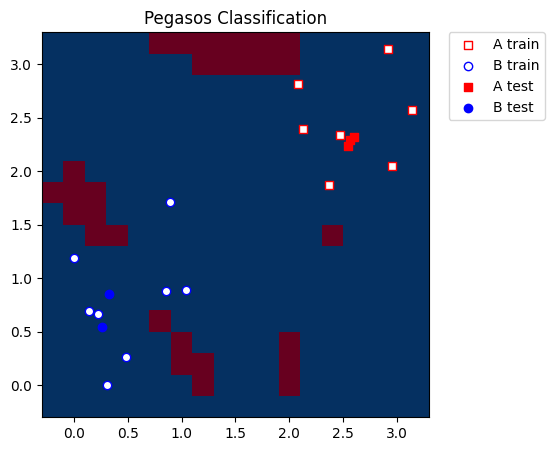

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
    x_train[:, 0][y_train == 0],
    x_train[:, 1][y_train == 0],
    marker="s",
    facecolors="w",
    edgecolors="r",
    label="A train",
)
plt.scatter(
    x_train[:, 0][y_train == 1],
    x_train[:, 1][y_train == 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="B train",
)

plt.scatter(
    x_test[:, 0][y_test == 0],
    x_test[:, 1][y_test == 0],
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="A test",
)
plt.scatter(
    x_test[:, 0][y_test == 1],
    x_test[:, 1][y_test == 1],
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos Classification")
plt.show()

In [92]:
# token + backend
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
token = "79232e64fa632d6dc52dbcba74585a33ec8593fe06d654771e8e3805d1cfb4f029a8d2b4dc022194164e29c2c16746342a7abc849cac0e6d9b2a726ab4785731"
service = QiskitRuntimeService(channel = "ibm_quantum", token = token)
backend = service.backend('ibm_brisbane')
sampler = Sampler(backend)
X = x_train

In [93]:
from qiskit import transpile, QuantumCircuit
# Pegasos to a quantum backend
# Feature map and quantum kernel
feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=2, entanglement="linear")
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
feature_map_compiled = transpile(feature_map, backend=backend)

# Create a quantum circuit for the kernel
num_qubits = 127  # Adjust based on the backend capabilities
quantum_kernel_circuit = QuantumCircuit(num_qubits)
quantum_kernel_circuit.append(feature_map_compiled, range(num_qubits))
# Use QuantumCircuit for FidelityQuantumKernel
fidelity_quantum_kernel = FidelityQuantumKernel()
fidelity_quantum_kernel._quantum_circuit = quantum_kernel_circuit
# Pegasos QSVC model
num_steps = 100  # You can tune this
C = 1.0
model = PegasosQSVC(quantum_kernel=fidelity_quantum_kernel, C=C, num_steps=num_steps)

# Fit and evaluate
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")
backend_info()
#model train

Train accuracy: 0.6000
Test accuracy: 0.4000
bckend = ibm_brisbane srart = 2025-04-29T01:02:17.862Z end = 2025-04-29T01:02:19.382Z elapsed_time = 0:00:01.520000 usage_seconds = 0         estimated_running_time_seconds = None


In [94]:
!pip install datetime

In [95]:
# List recent jobs submitted by the runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel = "ibm_quantum", token = token)  # Ensure you’ve authenticated
jobs = service.jobs(limit=5, backend_name="ibm_brisbane")  # You can also filter by job status
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=5>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2025-01-23 14:45:10', stop='2025-01-23 14:45:29', size=4096>)])}, 'version': 2})

In [96]:
from datetime import datetime

In [97]:
import requests
# transfer function to top and call the function to the QSVC
# chalenge: create quantum cluster with quantum backend (notebook 6.3)
def difference(ended, created):# '2025-04-29T01:02:19.382Z' - '2025-04-29T01:02:17.862Z'
    date_end = datetime.strptime(ended, "%Y-%m-%dT%H:%M:%S.%fZ")
    date_created = datetime.strptime(created, "%Y-%m-%dT%H:%M:%S.%fZ")
    time = date_end -date_created

    return time
def backend_info():
    token = "79232e64fa632d6dc52dbcba74585a33ec8593fe06d654771e8e3805d1cfb4f029a8d2b4dc022194164e29c2c16746342a7abc849cac0e6d9b2a726ab4785731"
    response = requests.request(
        "GET",
        "https://api.quantum-computing.ibm.com/runtime/workloads/me",
        headers={
            "Accept": "application/json",
            "Authorization": "Bearer " + token
        },
    )
    #print(response.json())
    json_res = response.json()
    json_res['workloads'][0]
    backend = json_res['workloads'][0]["backend"]
    created = json_res['workloads'][0]["created"]
    ended = json_res['workloads'][0]["ended"]
    elapsed_time = difference(ended, created) #json_res['workloads'][0]["usage_time"]
    usage_seconds = json_res['workloads'][0]["usage_seconds"]
    estimated_running_time_seconds = json_res['workloads'][0]["estimated_running_time_seconds"]
    print(f'bckend = {backend} srart = {created} end = {ended} elapsed_time = {elapsed_time} usage_seconds = {usage_seconds} \
        estimated_running_time_seconds = {estimated_running_time_seconds}')




In [98]:
from qiskit_machine_learning.algorithms.classifiers import QSVC
# QSVC
# Initialize QSVC
qsvc = QSVC(quantum_kernel=fidelity_quantum_kernel)

# Train QSVC
qsvc.fit(x_train, y_train)

# Evaluate QSVC
score = qsvc.score(x_train, y_train)
print(f"Quantum Kernel QSVC Train Accuracy: {score:.4f}")
score = qsvc.score(x_test, y_test)
print(f"Quantum Kernel QSVC Test Accuracy: {score:.4f}")

Quantum Kernel QSVC Train Accuracy: 0.7333
Quantum Kernel QSVC Test Accuracy: 0.8000


- With the current QML methosd how can we aprimorate the performance, get less runtime. (speed up)

- Is it worth the process to transform classical data in quantum data?

- Once the data is transformed, the Qmodel is optimal then the traditional Qmodel?

- The quantum computer suffer from error. So we can investigate quantum error correction